In [1]:
!pip install snap
!pip install  nibabel

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import torch
import nibabel as nib
import numpy as np
from pathlib import Path
import os


def transform_geo_dist(dist, gt, label_name):
    margin = 0.5

    def _transform_layer(dist_layer, gt_layer):
        fg = (gt_layer == 1)
        bg = (gt_layer == 0)
        dist_layer[fg] = torch.clamp_min(dist_layer[fg], 0.0)
        dist_layer[bg] = torch.clamp_max(dist_layer[bg], 0.0)

        if torch.sum(fg) == 0:
            return torch.full_like(dist_layer, -1)

        fg_max = dist_layer[fg].max()
        dist_layer[bg] = torch.clamp_min(dist_layer[bg], -fg_max)

        dist_layer = dist_layer / (fg_max + 1e-8)

        if label_name == "fast_sgc_margin":
            dist_layer[fg] = dist_layer[fg] * (1.0 - margin) + margin
            dist_layer[bg] = dist_layer[bg] * (1.0 - margin) - margin

        dist_layer = torch.clamp(dist_layer, -1.0, 1.0)

        if label_name == "fast_sgc_clamp":
            dist_layer[(gt_layer > 0) & (dist_layer <= 0)] = dist_layer[dist_layer > 0.0001].min()
            dist_layer[(gt_layer == 0) & (dist_layer >= 0)] = dist_layer[dist_layer < -0.0001].max()

        return dist_layer

    for i in range(dist.shape[-1]):
        dist[..., i] = _transform_layer(dist[..., i], gt[..., i])
    return dist


def transform_gd_dist(dist, gt):
    def _transform_gd_dist_layer(dist_layer, gt_layer):
        # Ensure the shapes match and masks are boolean
        fg = (gt_layer == 1)
        bg = (gt_layer == 0)

        dist_layer[fg] = torch.clamp_min(dist_layer[fg], 0.52)
        dist_layer[bg] = torch.clamp_max(dist_layer[bg], 0.48)

        return dist_layer

    gt = gt[..., 0]
    print(f"gt.shape: {gt.shape}")


    for index in range(dist.shape[-1]):
        dist_layer = dist[..., index]
        gt_layer = gt[..., index]

        print("dist_layer shape:", dist_layer.shape)
        print("gt_layer shape:", gt_layer.shape)

        # Apply per-layer transformation
        dist[..., index] = _transform_gd_dist_layer(dist_layer, gt_layer)

    # Sanity check after processing
    assert not torch.any(torch.isnan(dist)), "NaNs introduced during transformation"

    return dist



def process_single_image(image_path, gt_path, output_path, label_name="fast_sgc_margin", dataset="BRATS", device="cpu"):
    print(f"Processing {image_path.name}")
    hard_gt_path = gt_path

    if dataset == "BRATS":
        hard_gt = np.transpose(merge_seg(hard_gt_path), [3, 2, 1, 0])

    else:
        hard_gt = get_data(gt_path, is_seg=True)[0]
        hard_gt = np.transpose(np.expand_dims(hard_gt, 0), [3, 2, 1, 0])

    hard_gt = torch.tensor(hard_gt, device=device)
    raw_geo = nib.load(image_path).get_fdata()
    print(f"Saved to {output_path}")


In [ ]:
import os
from pathlib import Path
import nibabel as nib
import numpy as np
from skimage.morphology import reconstruction  # Geodesic transform
import shutil

def geodesic_transform(image_array):
    # Normalize image between 0 and 1
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

    # Use image itself as both marker and mask for demonstration
    marker = np.copy(image_array)
    marker[1:-1, 1:-1, 1:-1] = 0  # Zero out the center to force geodesic propagation

    transformed = reconstruction(marker, image_array, method='dilation')
    return transformed

def process_sample(sample_dir):
    sample_path = Path(sample_dir)
    sample_name = sample_path.name
    output_dir = sample_path.parent / f"{sample_name}_transformed"
    output_dir.mkdir(exist_ok=True)

    image_files = [f for f in sample_path.glob("*.nii*") if "seg" not in f.stem]

    for img_file in image_files:
        print(f"Processing {img_file.name}...")

        # Load
        img = nib.load(str(img_file))
        img_data = img.get_fdata()

        # Apply geodesic transform
        transformed_data = geodesic_transform(img_data)

        # Save transformed image
        transformed_img = nib.Nifti1Image(transformed_data, affine=img.affine)
        save_path = output_dir / img_file.name
        nib.save(transformed_img, str(save_path))

    print(f"Saved transformed images in: {output_dir}")


In [14]:
def process_sample(sample_dir):
    sample_path = Path(sample_dir)
    sample_name = sample_path.name
    output_dir = sample_path.parent / f"{sample_name}_transformed"
    output_dir.mkdir(exist_ok=True)

    image_files = [f for f in sample_path.glob("*.nii*") if "seg" in f.stem]

    for img_file in image_files:
        print(f"Processing {img_file.name} in {sample_name}...")
        img = nib.load(str(img_file))
        img_data = img.get_fdata()
        transformed_data = geodesic_transform(img_data)
        transformed_img = nib.Nifti1Image(transformed_data, affine=img.affine)
        save_path = output_dir / img_file.name
        nib.save(transformed_img, str(save_path))

    print(f"Saved transformed images in: {output_dir}")

# Batch processing: loop through all samples
base_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData"
base_path = Path(base_dir)

sample_num = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]



# Loop over all folders starting with BraTS20_Training_
for sample_folder in base_path.glob("BraTS20_Training_*"):
    if sample_folder.is_dir():
        folder_num = int(sample_folder.name.split("_")[-1])
        if folder_num in sample_num:
            continue
        else:
            process_sample(sample_folder)

In [15]:


def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

"""
class EOFormerModel(nn.Module):

    def __init__(self, num_classes=2):
        super(EOFormerModel, self).__init__()
        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x
"""


class EOFormerModel(nn.Module):
    def __init__(self, num_classes=2):
        super(EOFormerModel, self).__init__()

        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, num_classes, kernel_size=1)
        self.dropout = nn.Dropout3d(p=0.3)  # Adding dropout with a 30% probability

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # Dropout after the first convolution
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Dropout after the second convolution
        x = self.conv3(x)
        return x
    

def get_input_tensor(formatted_sample_num, sample_dir, sample_num):
    t1 = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t1.nii"))
    t1ce = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t1ce.nii"))
    t2 = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t2.nii"))
    flair = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_flair.nii"))

    input_np = np.stack([t1, t1ce, t2, flair], axis=0)
    input_np = (input_np - input_np.mean(axis=(1, 2, 3), keepdims=True)) / (
        input_np.std(axis=(1, 2, 3), keepdims=True) + 1e-8
    )
    input_tensor = torch.from_numpy(input_np).float().unsqueeze(0)  # [1, 4, D, H, W]
    return input_tensor


def get_ground_truth(sample_dir, sample_num):
    seg = load_nifti(os.path.join(sample_dir, f"{sample_num}_seg.nii"))
    seg = np.clip(seg, 0, 1)  # Binarize
    gt_tensor = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)  # [1, 1, D, H, W]
    return gt_tensor


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = torch.softmax(logits, dim=1)
        targets_onehot = torch.nn.functional.one_hot(targets.squeeze(1), num_classes).permute(0, 4, 1, 2, 3).float()
        dims = (0, 2, 3, 4)
        intersection = torch.sum(probs * targets_onehot, dims)
        cardinality = torch.sum(probs + targets_onehot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1 - dice_score.mean()


def visualize_prediction(gt_mask, pred_mask, slice_idx=77):
    gt_np = gt_mask.squeeze().detach().cpu().numpy()
    pred_np = pred_mask.squeeze().detach().cpu().numpy()

    if gt_np.ndim == 4:
        gt_np = gt_np[0]
    if pred_np.ndim == 4:
        pred_np = pred_np[0]

    gt_slice = gt_np[:, :, slice_idx]
    pred_slice = pred_np[:, :, slice_idx]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_slice, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_slice, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()


if __name__ == '__main__':
    model = EOFormerModel(num_classes=2)
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_samples = [f"BraTS20_Training_{i:03d}" for i in range(1, 41) if i not in (12, 15, 19, 20)]

    #train_samples = [f"BraTS20_Training_{i:03d}" for i in range(1, 20) if (i != 12 or 15)]  
    sample_root_dir = "Downloads/BRATS/BRATS/MICCAI_BraTS2020_TrainingData"

    for epoch in range(20):
        model.train()
        total_loss = 0
        for sample_num in train_samples:
            sample_dir = os.path.join(sample_root_dir, sample_num)
            input_tensor = get_input_tensor(sample_num, sample_dir, sample_num)
            gt_mask = get_ground_truth(sample_dir, sample_num)

            output = model(input_tensor)
            loss = criterion(output, gt_mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_samples):.4f}")

    # After training: run inference and visualize predictions
    model.eval()
    inputs, preds, gts = [], [], []

    test_samples = [f"BraTS20_Validation_{i:03d}" for i in range(41, 65)]
    sample_root_dir = "Downloads/BRATS/BRATS/MICCAI_BraTS2020_TrainingData"

    with torch.no_grad():
        for sample_num in test_samples:
            sample_dir = os.path.join(sample_root_dir, sample_num)
            input_tensor = get_input_tensor(sample_num, sample_dir, sample_num)
            gt_mask = get_ground_truth(sample_dir, sample_num)

            output = model(input_tensor)
            pred = torch.argmax(torch.softmax(output, dim=1), dim=1)

            inputs.append(input_tensor)
            preds.append(pred)
            #gts.append(gt_mask)

    # Visualize
    for i in range(len(preds)):
        visualize_prediction(gts[i], preds[i])


Epoch 1, Loss: 0.6167
Epoch 2, Loss: 0.6000
Epoch 3, Loss: 0.5865
Epoch 4, Loss: 0.5821
Epoch 5, Loss: 0.5695
Epoch 6, Loss: 0.5639
Epoch 7, Loss: 0.5525
Epoch 8, Loss: 0.5506
Epoch 9, Loss: 0.5453
Epoch 10, Loss: 0.5395
Epoch 11, Loss: 0.5375
Epoch 12, Loss: 0.5258
Epoch 13, Loss: 0.5231
Epoch 14, Loss: 0.5197
Epoch 15, Loss: 0.5145
Epoch 16, Loss: 0.5077
Epoch 17, Loss: 0.5035
Epoch 18, Loss: 0.4977
Epoch 19, Loss: 0.4877
Epoch 20, Loss: 0.4880


FileNotFoundError: No such file or no access: 'Downloads/BRATS/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Validation_041/BraTS20_Validation_041_t1.nii'

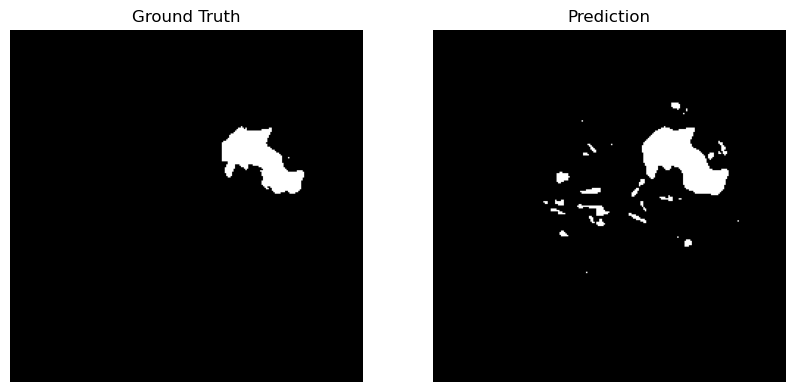

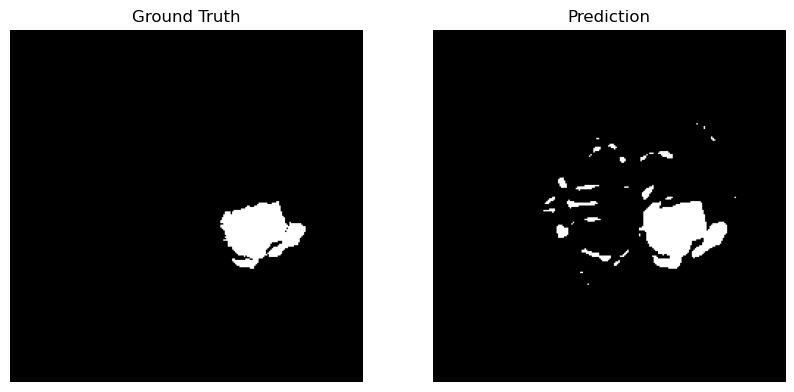

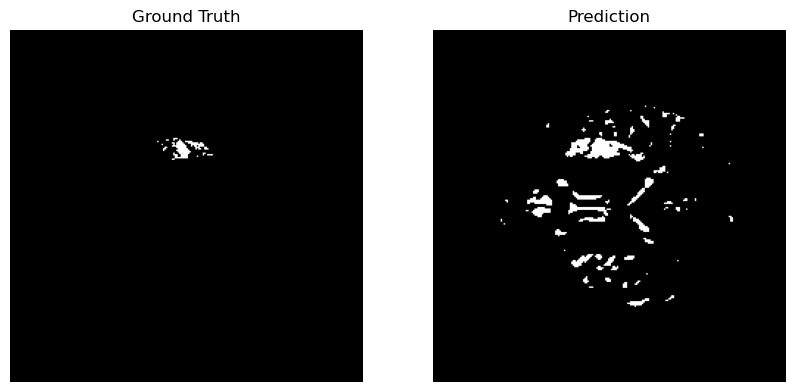

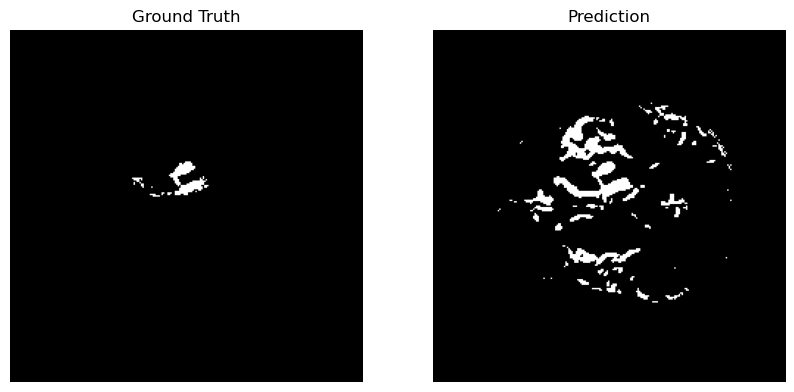

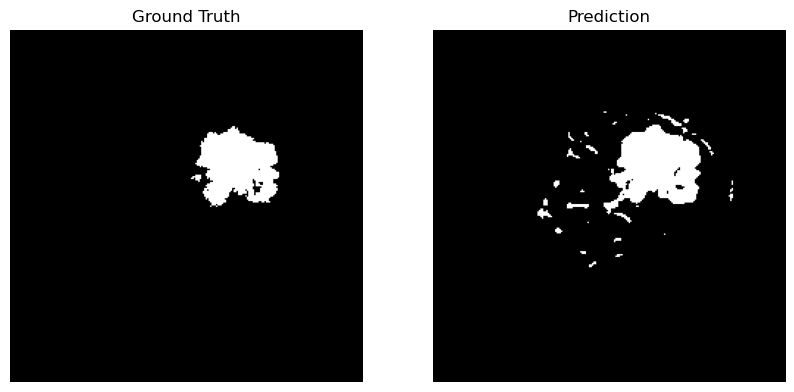

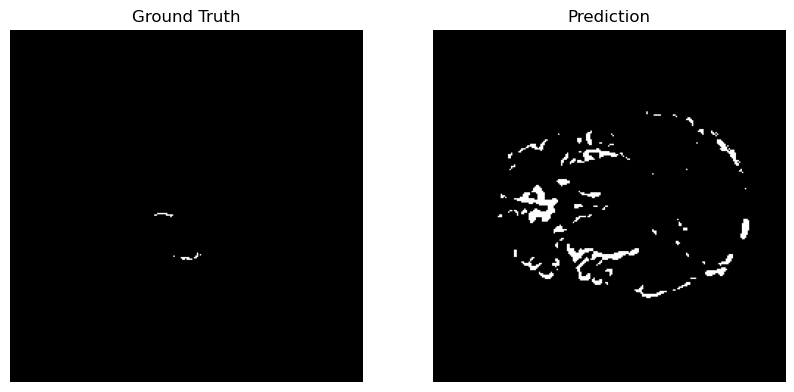

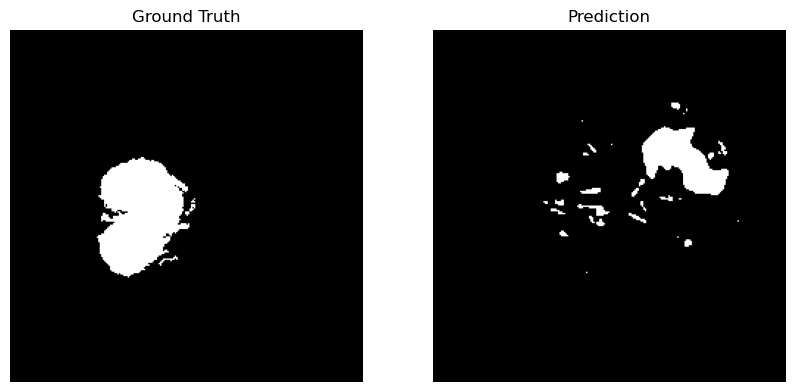

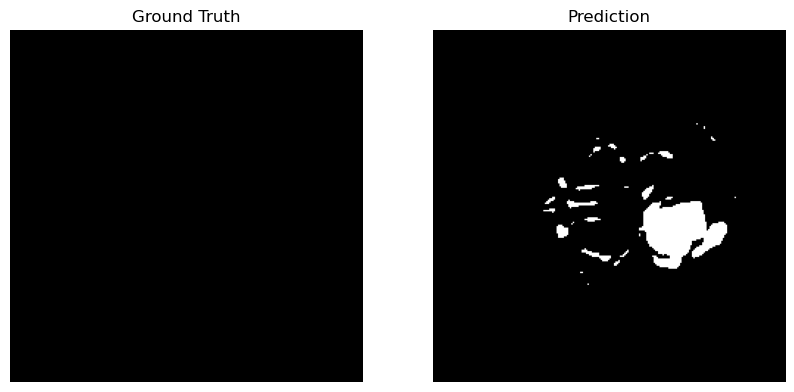

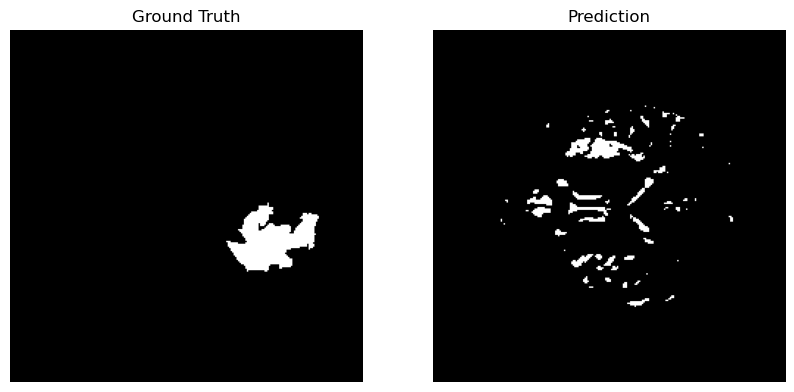

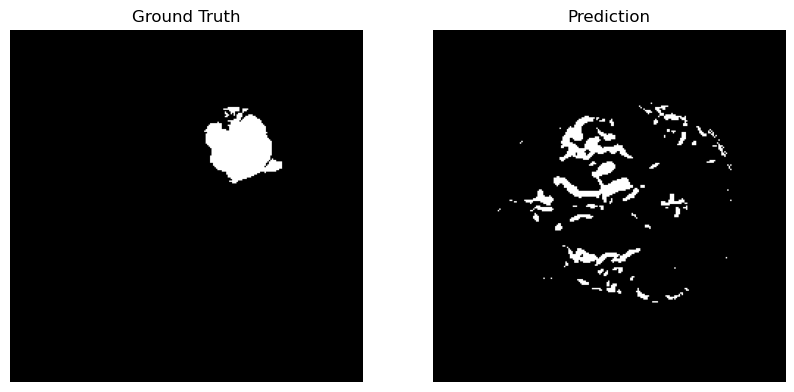

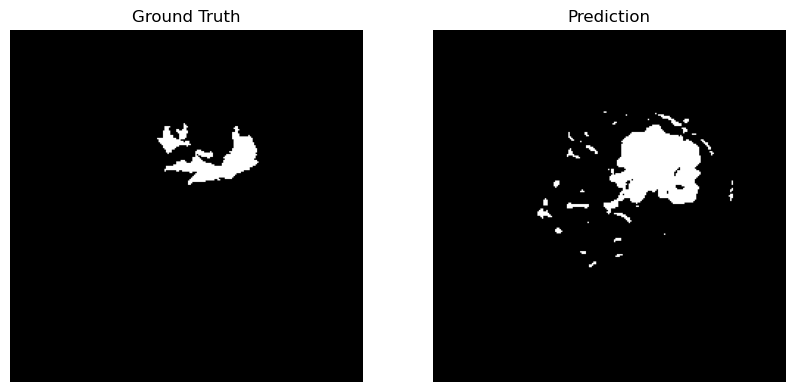

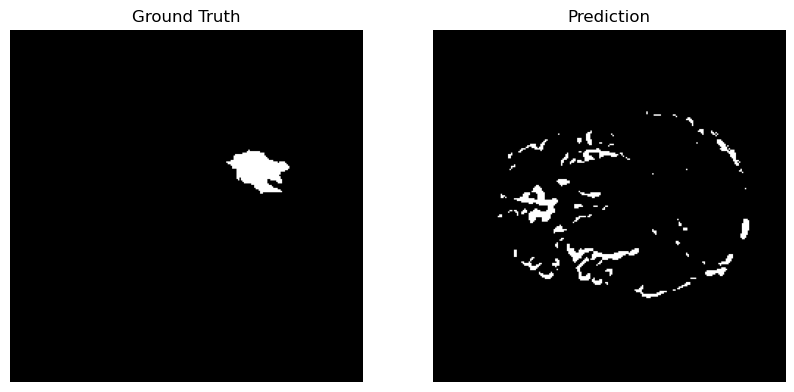

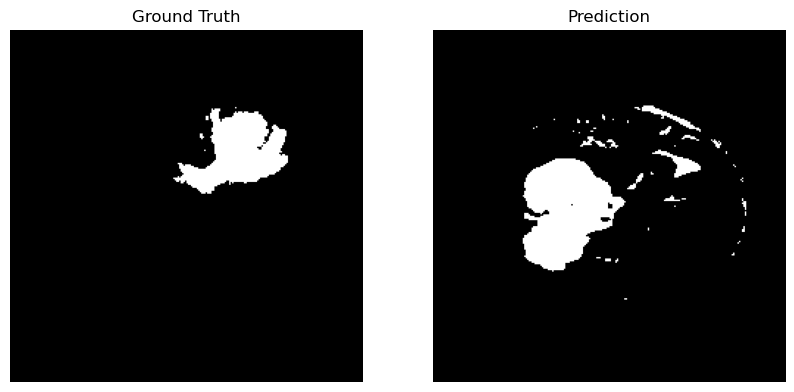

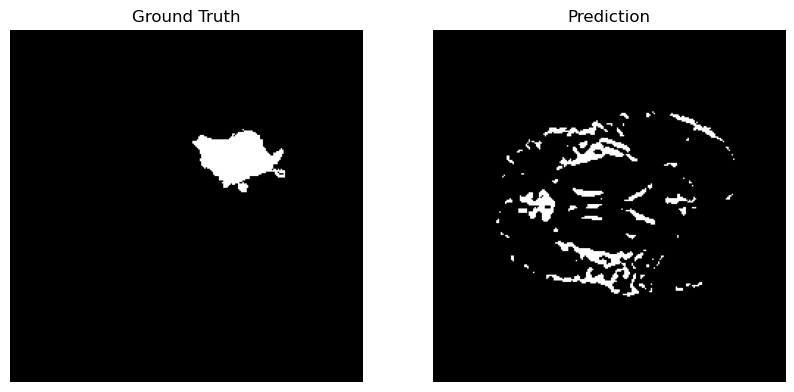

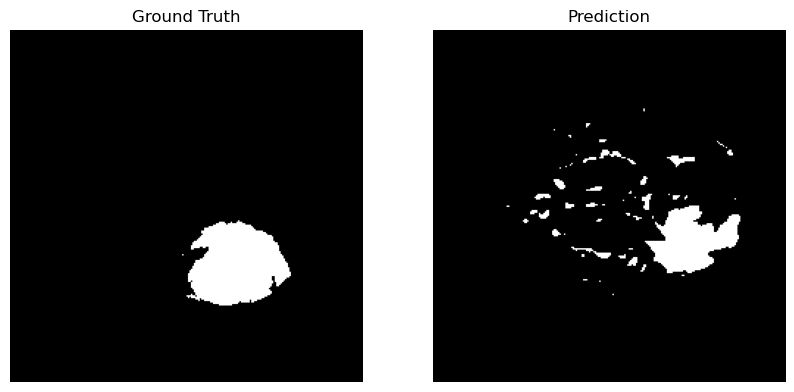

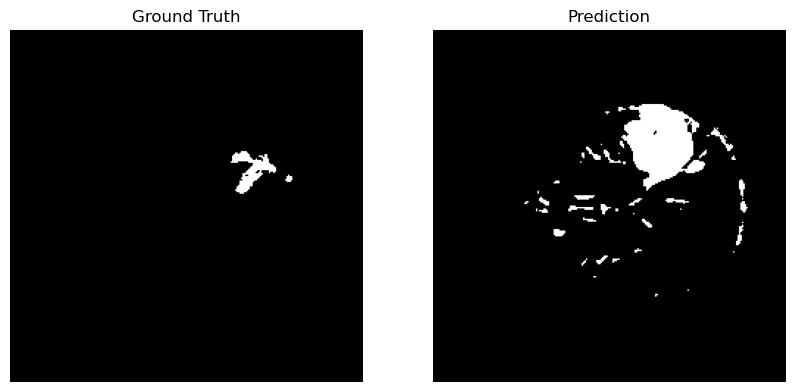

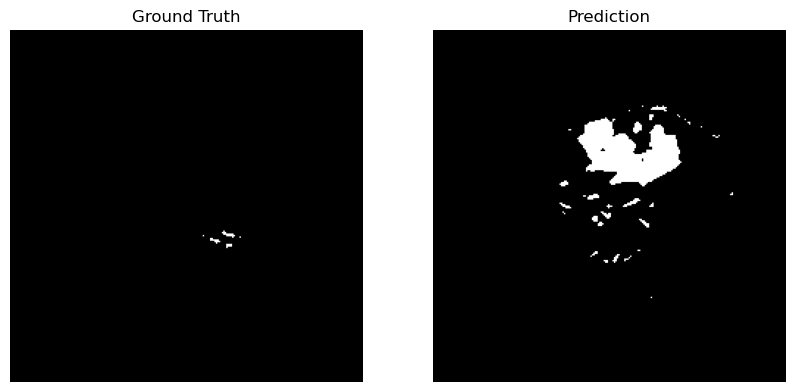

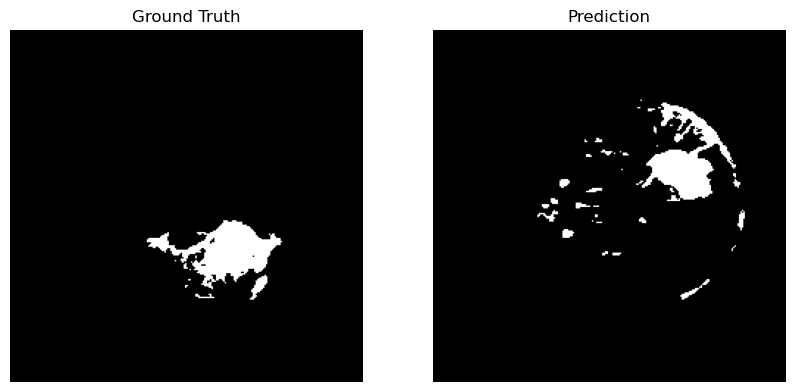

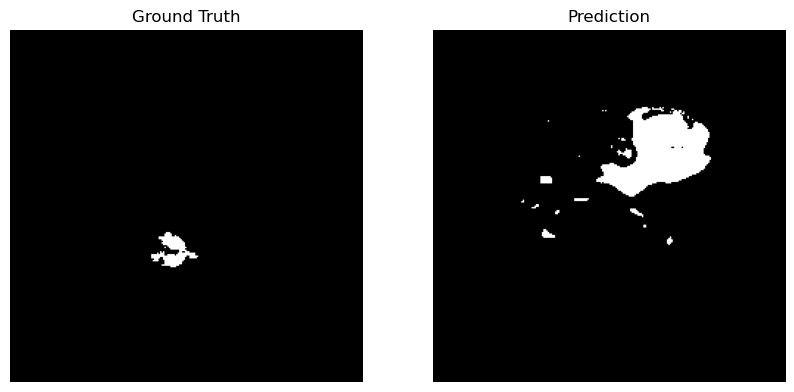

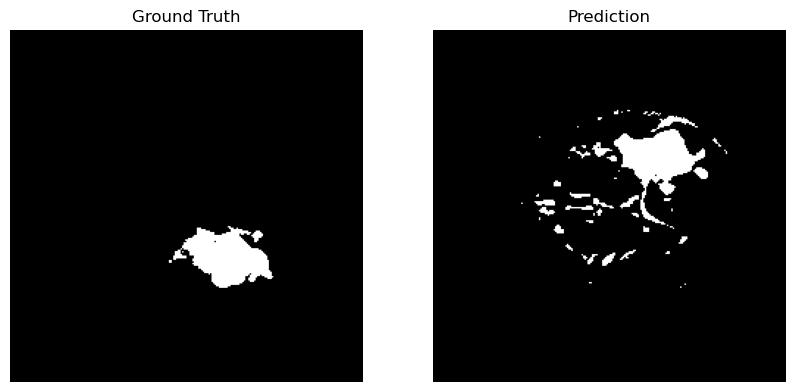

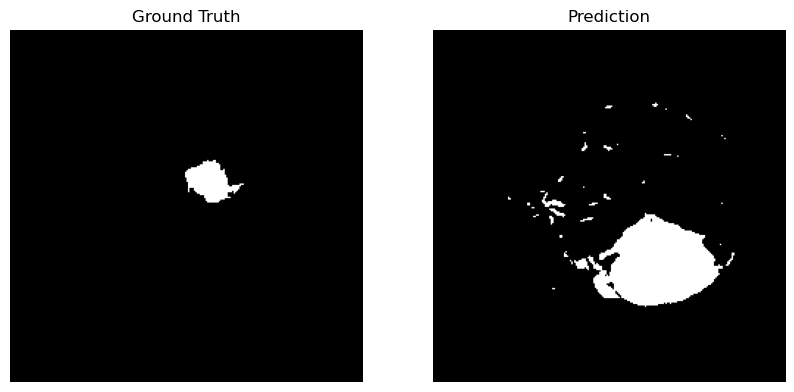

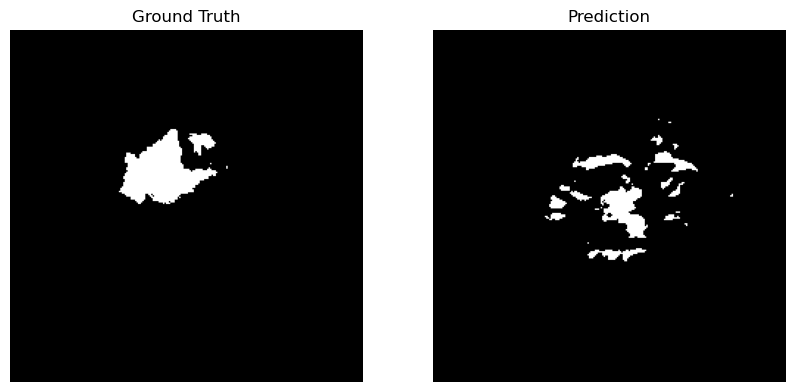

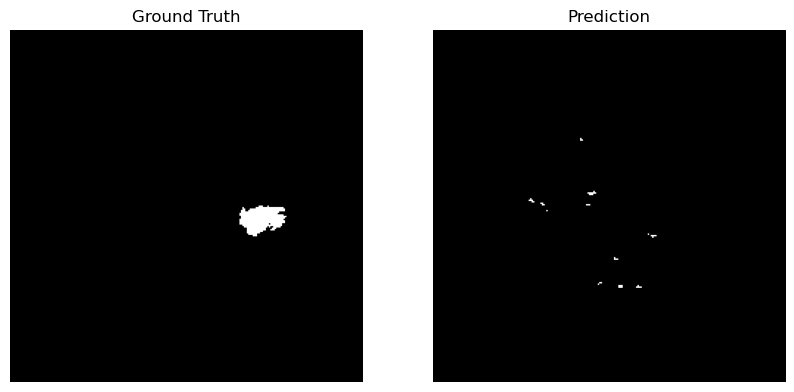

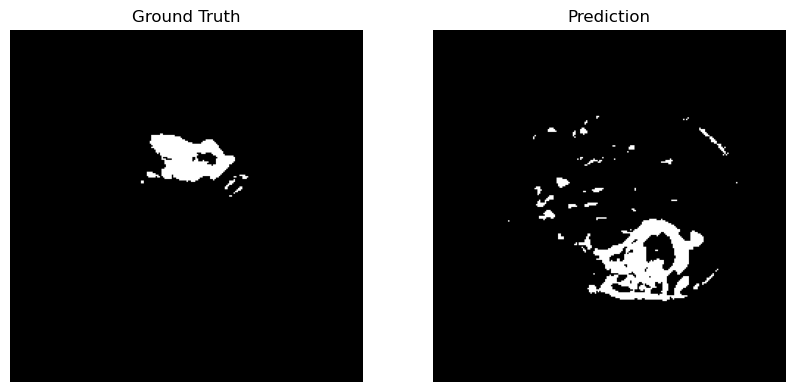

In [20]:
test_samples = [f"BraTS20_Training_{i:03d}" for i in range(41, 65)]
sample_root_dir = "Downloads/BRATS/BRATS/MICCAI_BraTS2020_TrainingData"

with torch.no_grad():
    for sample_num in test_samples:
        sample_dir = os.path.join(sample_root_dir, sample_num)
        input_tensor = get_input_tensor(sample_num, sample_dir, sample_num)
        gt_mask = get_ground_truth(sample_dir, sample_num)

        output = model(input_tensor)
        pred = torch.argmax(torch.softmax(output, dim=1), dim=1)

        inputs.append(input_tensor)
        preds.append(pred)
        gts.append(gt_mask)

# Visualize
for i in range(len(preds)):
    for j in range(len(gts)):
        if i == j:
            visualize_prediction(gts[i], preds[i])


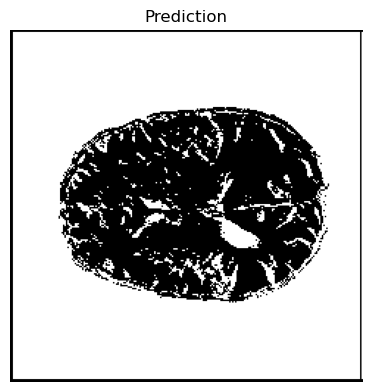

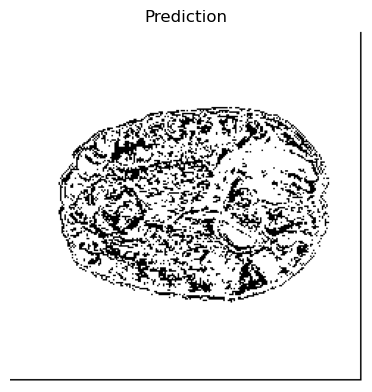

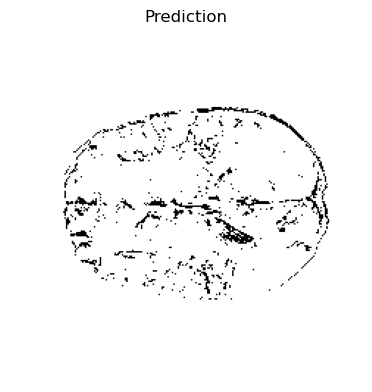

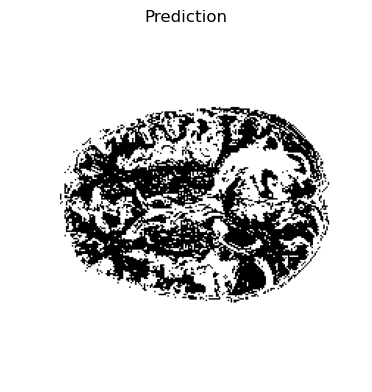

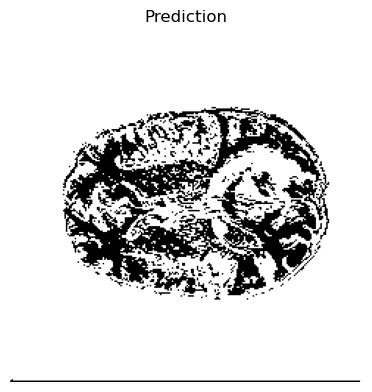

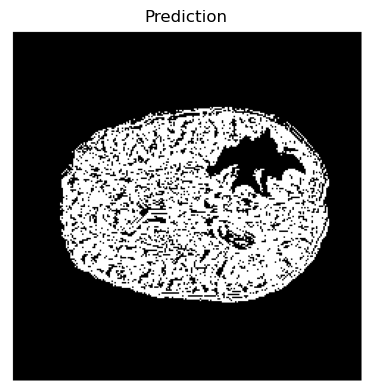

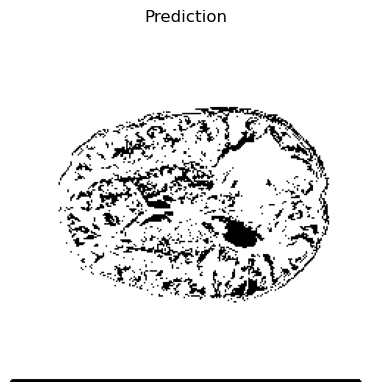

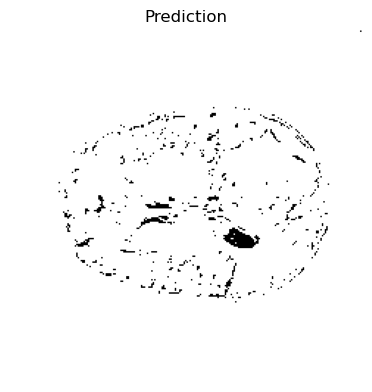

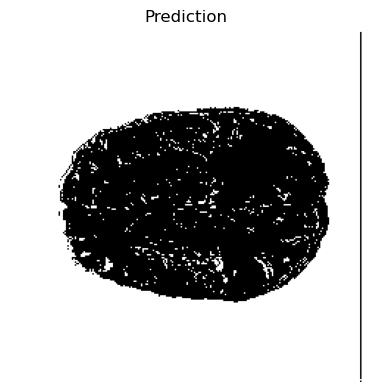

In [ ]:

def visualize_prediction(pred_mask, slice_idx = 77):
    train_samples = [f"BraTS20_Training_{i:03d}" for i in range(1, 41) if i not in (12, 15, 19, 20)]

    #gt_np = gt_mask.squeeze().detach().cpu().numpy()
    pred_np = pred_mask.squeeze().detach().cpu().numpy()

    if pred_np.ndim == 4:
        pred_np = pred_np[0]

   
    pred_slice = pred_np[:, :, slice_idx]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 2)
    plt.imshow(pred_slice, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()


inputs, preds, gts = [], [], []

test_samples = [f"BraTS20_Validation_{i:03d}" for i in range(1, 10)]
sample_root_dir = "Downloads/BRATS/BRATS/MICCAI_BraTS2020_ValidationData"

with torch.no_grad():
    for sample_num in test_samples:
        sample_dir = os.path.join(sample_root_dir, sample_num)
        #input_tensor = get_input_tensor(sample_num, sample_dir, sample_num)
        #gt_mask = get_ground_truth(sample_dir, sample_num)

        output = model(input_tensor)
        pred = torch.argmax(torch.softmax(output, dim=1), dim=1)

        DiceLoss(pred, input)

        #inputs.append(input_tensor)
        preds.append(pred)
        #gts.append(gt_mask)

# Visualize
for i in range(len(preds)):
    visualize_prediction(preds[i])
